In [1]:
import pm4py
import pandas

In [6]:
def code2text_Pheonix(event_log):
    #translatets root_codes for pheonix data
    translationMap = {"1":"Make Public Statement", "2":"Appeal", "3":"Express intent to cooperate",
                    "4":"Consult", "5":"Engage in diplomatic cooperation","6":"Engage in material cooperation",
                    "7":"Provide aid", "8":"Yield", "9":"Investigate", 
                    "10":"Demand", "11":"Disapprove", "12":"Reject", 
                    "13":"Threaten", "14":"Protest", "15":"Exhibit force posture", 
                    "16":"Reduce relations", "17":"Coerce", "18":"Assault",
                    "19":"Fight","20":"Use unconventional mass violence"}
    def translate(x):
        return translationMap[str(x)]
    event_log['root_code'] = event_log['root_code'].apply(translate)
    return event_log

def preprocess(event_log, key="empty"):

    #extract root country
    event_log["source_root"] = event_log["source"].apply(lambda x : x[0:3])
    event_log["target_root"] = event_log["target"].apply(lambda x : x[0:3])
    #create conflict_id
    event_log["conflict_id"] = event_log["source_root"] + event_log["target_root"]
    #select conflict
    if key != "empty":
        event_log = event_log[event_log.conflict_id == key]

    #event_log = event_log[event_log.source == "DDR"]
    #decode codes
    event_log = code2text_Pheonix(event_log)
    

    

    #format to pm4py
    event_log = pm4py.format_dataframe(event_log, case_id='conflict_id', activity_key='root_code', timestamp_key='story_date')
    start_activities = pm4py.get_start_activities(event_log)
    end_activities = pm4py.get_end_activities(event_log)
    print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
    return event_log

def import_csv(file_path):
    event_log = pandas.read_csv(file_path, sep=',')
    return event_log 

In [7]:
def make_process_tree(event_log, show=True):
    process_tree = pm4py.discover_process_tree_inductive(event_log)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    if(show):
        pm4py.view_bpmn(bpmn_model)
    return process_tree

def make_dfg(event_log, minThresh = 1, show=True):
    dfg, start_activities, end_activities = pm4py.discover_dfg(event_log, case_id_key='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
    print(start_activities)
    dfg = {activities: value for activities, value in dfg.items() if value >= minThresh}

    if show:
        pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

def make_petrinet(event_log, show=True):
    #no clue what markings are but this should get us a petrinet
    #network, iMarking, fMarking = pm4py.discovery.discover_petri_net_alpha(event_log)
    #network, iMarking, fMarking = pm4py.discover_petri_net_inductive(event_log,noise_threshold = 0.7)
    network, iMarking, fMarking = pm4py.discover_petri_net_heuristics(event_log)
    if show:
        pm4py.view_petri_net(network, iMarking, fMarking)
    return network, iMarking, fMarking
def make_bpmn(event_log, show=True):
    efg = pm4py.discover_bpmn_inductive(event_log, noise_threshold = 0.7, multi_processing=True)
    if show:
        pm4py.view_bpmn(efg)
    return efg

Start activities: {'Coerce': 1}
End activities: {'Coerce': 1}
{'Coerce': 1}


/tmp/ipykernel_20475/386088534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log['root_code'] = event_log['root_code'].apply(translate)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

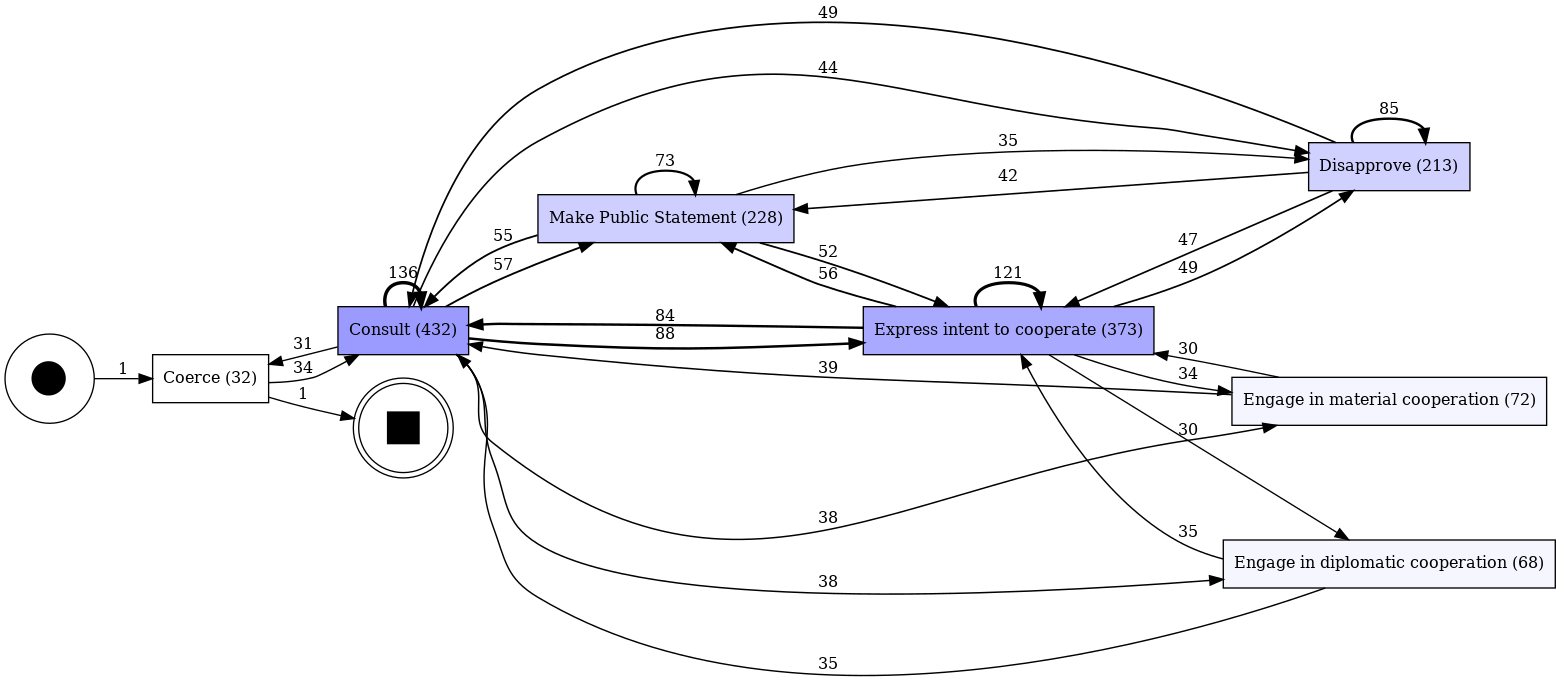

Start activities: {'Express intent to cooperate': 1}
End activities: {'Reject': 1}
{'Express intent to cooperate': 1}


/tmp/ipykernel_20475/386088534.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_log['root_code'] = event_log['root_code'].apply(translate)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/home/sasha/.local/lib/python3.10/site-packages/pm4py/utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

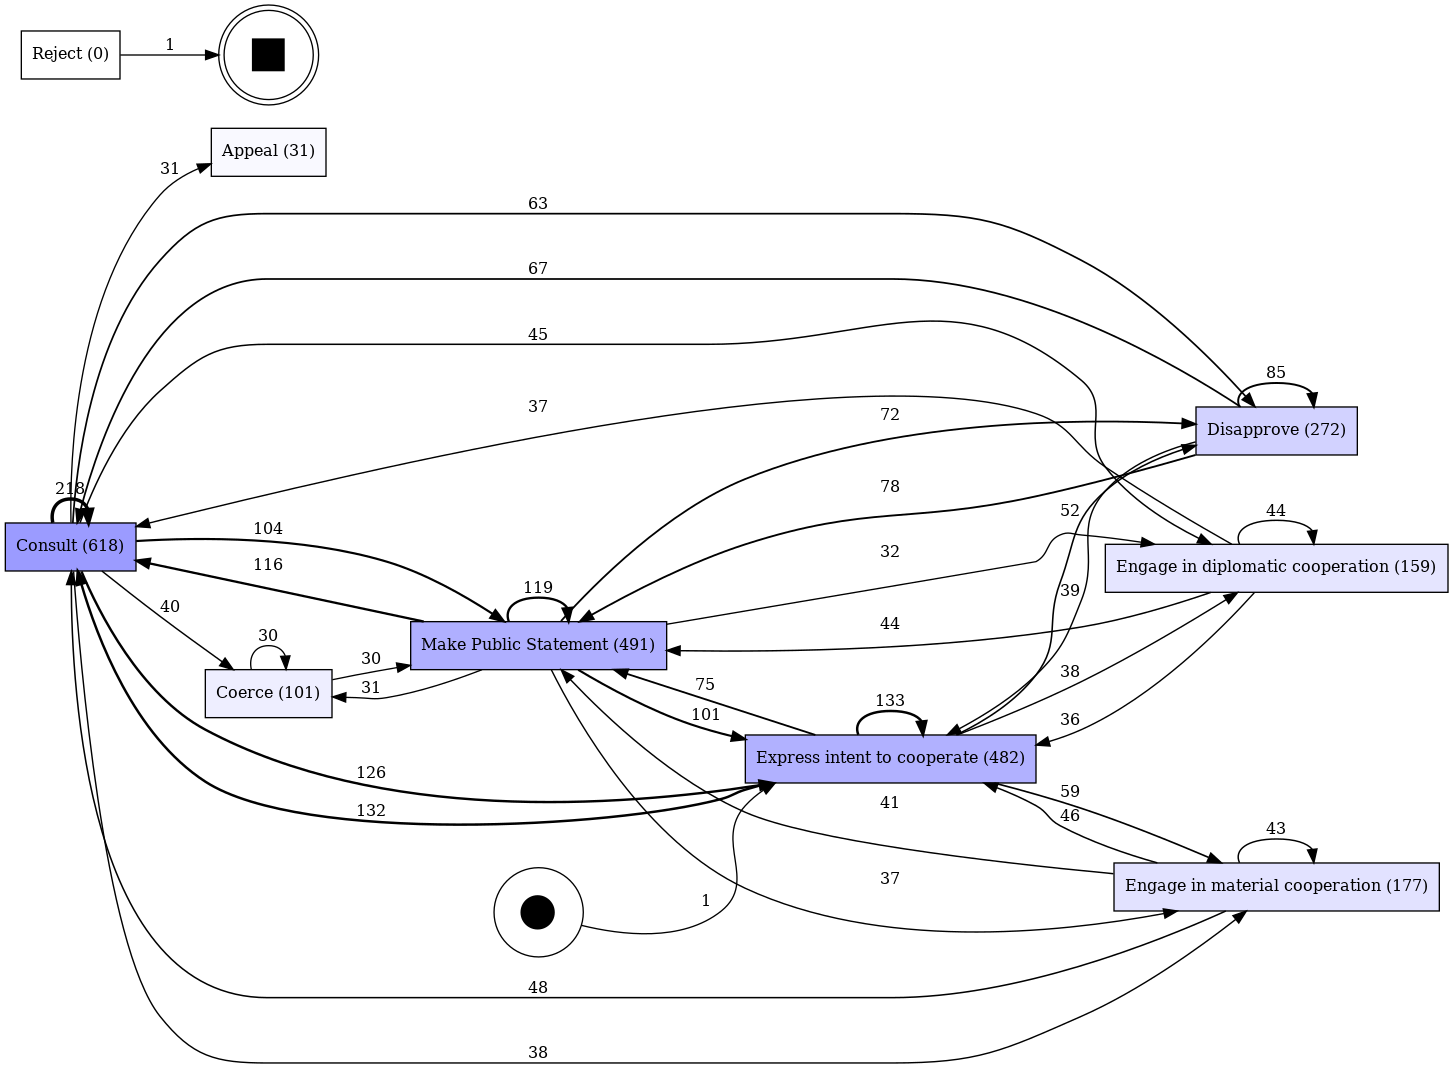

In [9]:
event_log = import_csv("/home/sasha/Desktop/historicalEventData/DOI-10-13012-b2idb-0647142_v3/PhoenixBLN-NYT_1980-2018.csv")
event_log_r = preprocess(event_log, key="RUSUSA")
make_dfg(event_log_r,minThresh =30)
event_log_u = preprocess(event_log, key="USARUS")
make_dfg(event_log_u,minThresh =30)
#make_bpmn(event_log)
#make_process_tree(event_log)
#make_petrinet(event_log)